In [32]:
%load_ext autoreload
%autoreload 2

# python
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import pandas as pd
import sys
sys.path.append("../")

# custom
import Utils as ut
from Utils import loadALEPH2004Result, loadWeights, ensembleWeights, calc_hist, plotThrust
import dataloader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
aleph = ut.loadALEPH2004Result()
print(aleph["aleph_log_thrust_errs"])
print(aleph["aleph_log_thrust_errs"] - np.linalg.norm(aleph["aleph_log_thrust_errs_individual"], axis=1))

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -
[0.00059364 0.00761793 0.01701719 0.00781693 0.00746136 0.00677942
 0.00814534 0.0077546  0.0070463  0.00968856 0.00883575 0.00875478
 0.00948643 0.00881046 0.00790756 0.00968362 0.00909576 0.0086974
 0.0068823  0.00685199 0.00751772 0.00534918 0.00509836 0.00535912
 0.00636601 0.00561443 0.00563602 0.00609543 0.00640759 0.00483177
 0.00531451 0.00450477 0.00354568 0.00293204 0.00207306 0.00221681
 0.00172053 0.00111097 0.00080795 0.00057632 0.00050214 0.00029193]
[ 0.00000000e+00  0.00000000e+00  3.46944695e-18  0.00000000e+00
 -8.67361738e-19  0.00000000e+00  1.73472348e-18 -8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73472348e-18
  1.73472348e-18 -1.73472348e-18  0.00000000e+00  8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:114: RuntimeWarning: divide by zero encountered in log
  aleph_log_bins = np.log(aleph_bins)


In [34]:
# load data
import json
with open("../training_conf.json") as f:
      training_conf = json.load(f)
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(training_conf)
# flatten
reco_data = reco_data.flatten()
reco_mc = reco_mc.flatten()
gen_mc = gen_mc.flatten()
print(reco_data.shape, reco_mc.shape, gen_mc.shape, pass_reco.shape, pass_gen.shape)
# apply selection
reco_mc = reco_mc[pass_reco]
gen_mc = gen_mc[pass_gen] # fully efficient
print(reco_mc.shape, gen_mc.shape)

(1365440,) 1326312
(771597,) 751861
(1326312,) (973769,) (973769,) (973769,) (973769,)
(751861,) (973769,)


In [35]:
# plotting configuration
conf = {
    "logtau" : {
        "aleph" : {
            "x" : aleph["aleph_log_midbins"], 
            "y": aleph["aleph_log_thrust"], 
            "xerr": aleph["aleph_log_binwidths"]/2, 
            "yerr": aleph["aleph_log_thrust_errs"], 
            "bins" : aleph["aleph_log_bins"]
        },
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax2_xscale" : "linear",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_xlabel" : r"$\log(\tau)$",
        "ax2_ylim" : [0.01, 1.99],
        "bins" : np.linspace(aleph["log_bins_min"], np.log(0.5), 51),
        "legend" : "lower right",
        "legend_bbox" : (0.98, 0.0)
    },
}    

In [36]:
# Load the weights
ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-745de56e/*/model_weights*" # Nominal result
e_weights = loadWeights(ensemble)
print(e_weights.shape)

(1, 200, 973769)


In [42]:
totalKeep = e_weights.shape[1] # keep all
# totalKeep = 100 # keep only the first 100 weights
Ns = [1, 4, 8, 10, 12, 16, 20, 32]
ensemble_weights = []
for N in Ns:
    print(e_weights[:,:totalKeep].shape)
    ensemble_weights.append(ensembleWeights(e_weights[:,:totalKeep], N))

(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)
(1, 200, 973769)


In [43]:
# make histograms
plots = {}
for key, val in conf.items():
    plots[key] = {}
    for iN, N in enumerate(Ns):
        for iW, weights in enumerate(np.squeeze(ensemble_weights[iN], axis=0)):
            plots[key][f"unifold_{N}_ensemble{iW}"] = calc_hist(gen_mc, bins=val["bins"], density=True, weights=weights.flatten())

In [44]:
errors = {}
for key, val in conf.items():
    errors[key] = {}

    # get the ensemble uncertainty
    err = []
    for iN, N in enumerate(Ns):
        # ensemble error is the spread of the possible bin values
        ensemble_hists = []
        for iW in range(1, ensemble_weights[iN].shape[1]): # don't include the nominal setting
            ensemble_hists.append(plots[key][f"unifold_{N}_ensemble{iW}"][0]) 
        ensemble_hists = np.array(ensemble_hists)
        total_ensemble_err = np.std(ensemble_hists, axis=0) # take std over the errors
        err.append(list(total_ensemble_err))
    err = np.stack(err, axis=1)

    # create entry for the errors
    errors[key][f"unifold_ensemble_errs"] = {
        "individual" : err,
    }

/tmp/ipykernel_348545/44351029.py:34: RuntimeWarning: invalid value encountered in divide
  inPlots[f"component_{iN}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,iN] / nominal[0], "color": colors[iN], "label": f"Ensemble N={Ns[iN]}", "ls": "-"} # f"Component {i}"
/tmp/ipykernel_348545/44351029.py:38: RuntimeWarning: invalid value encountered in divide
  ratio_denom = [[individual[:,iN] / nominal[0]],]


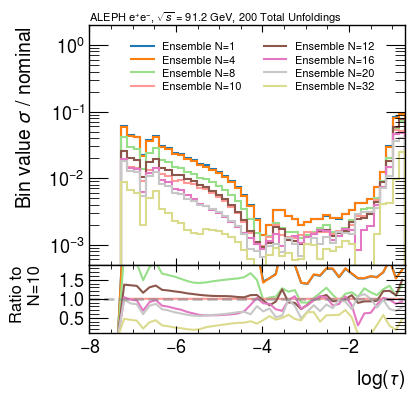

In [45]:
for key, val in conf.items():
        
    # bins
    bins = val["bins"]
    binwidths = bins[1:] - bins[:-1]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # style
    style = {
        "legend_loc" : "upper left",
        "legend_bbox" : (0.08, 1.0),
        "legend_ncol" : 2,
        "legend_fontsize" : 8,
        "ax1_ylabel" : r"Bin value $\sigma$ / nominal", # Fractional Relative Error",
        "ax1_yscale" : val["ax1_yscale"],
        "ax2_xlabel" : val["ax2_xlabel"],
        "ax2_xscale" : val["ax2_xscale"],
        "ax2_ylabel" : f'Ratio\nto N',
        "ax1_ylim" : [5*10**-4, 2*10**0], #[0.5*10**-6, 5*10**-1],
        "bins" : bins,
        "ax2_ylim" : [0.1,1.9],
    }
    
    # pick up the errors
    individual = np.abs(errors[key][f"unifold_ensemble_errs"]["individual"])
    
    # inPlots
    inPlots = {}
    
    # other variations
    colors = [plt.cm.tab20(i / individual.shape[1]) for i in range(individual.shape[1])]
    for iN, N in enumerate(Ns):
        nominal = plots[key][f"unifold_{N}_ensemble0"]
        inPlots[f"component_{iN}"] =  {"plotType": "stairs", "x": bins, "y": individual[:,iN] / nominal[0], "color": colors[iN], "label": f"Ensemble N={Ns[iN]}", "ls": "-"} # f"Component {i}"

        if N == 10:
            # ratio denominator to the first ensemble
            ratio_denom = [[individual[:,iN] / nominal[0]],]
            style["ax2_ylabel"] = f'Ratio to\n N={N}'
    
    header = r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV" + f", {totalKeep} Total Unfoldings"
    fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10, header=header)
    plt.savefig(f"ensemble-weights-{key}_Total{totalKeep}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()